In [1]:
import os
import numpy as np
import pandas as pd
from PIL import Image
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, Flatten, Dense, 
                                     RepeatVector, Embedding, LSTM, TimeDistributed)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.utils import Sequence
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.models import load_model

In [2]:
import tensorflow as tf

# GPU cihazlarını listele ve dinamik bellek ayarını etkinleştir
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    print("GPU başarıyla etkinleştirildi.")
else:
    print("GPU bulunamadı.")

# Basit bir TensorFlow işlemi
a = tf.constant([[1.0, 2.0]])
b = tf.constant([[3.0], [4.0]])
c = tf.matmul(a, b)  # Bu işlem GPU üzerinde çalışmalı
print(c)


GPU başarıyla etkinleştirildi.
tf.Tensor([[11.]], shape=(1, 1), dtype=float32)


In [3]:
# GPU cihazlarını listele
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"{len(gpus)} GPU bulundu:")
    for gpu in gpus:
        print(f" - {gpu.name}")
else:
    print("GPU bulunamadı.")


1 GPU bulundu:
 - /physical_device:GPU:0


In [4]:
# GPU'nun kullanılıp kullanılmadığını görmek için log açma
tf.debugging.set_log_device_placement(True)

# Basit bir TensorFlow işlemi
a = tf.constant([[1.0, 2.0]])
b = tf.constant([[3.0], [4.0]])
c = tf.matmul(a, b)  # Bu işlem GPU üzerinde çalışmalıdır
print(c)


tf.Tensor([[11.]], shape=(1, 1), dtype=float32)


In [2]:


def create_image_dataframe(folder_path):
    # Resim dosyalarının yolunu ve etiketlerini saklayacak listeler
    image_paths = []
    labels = []
    
    # Klasörün içindeki tüm dosyaları tarar
    for root, _, files in os.walk(folder_path):
        for file in files:
            # Yalnızca resim dosyalarını filtreleyelim (JPEG, PNG vb.)
            if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff', '.gif', '.heic')):
               
                full_path = os.path.join(root, file)
                image_paths.append(full_path)
                
                
                label = os.path.splitext(file)[0]  
                labels.append(label)
    
   
    df = pd.DataFrame({'file_path': image_paths, 'label': labels})
    return df


folder_path = r"C:\Users\omerf\Desktop\YapaySinir\resimler"

image_df = create_image_dataframe(folder_path)


In [3]:
image_df

,file_path,label
0,C:\Users\omerf\Desktop\YapaySinir\resimler\aba...,aba
1,C:\Users\omerf\Desktop\YapaySinir\resimler\abd...,abdest
2,C:\Users\omerf\Desktop\YapaySinir\resimler\abe...,abes
3,C:\Users\omerf\Desktop\YapaySinir\resimler\ade...,adet
4,C:\Users\omerf\Desktop\YapaySinir\resimler\afe...,aferin
...,...,...
788,C:\Users\omerf\Desktop\YapaySinir\resimler\ısp...,ıspanak
789,C:\Users\omerf\Desktop\YapaySinir\resimler\ısr...,ısrar
790,C:\Users\omerf\Desktop\YapaySinir\resimler\ışı...,ışık
791,C:\Users\omerf\Desktop\YapaySinir\resimler\şük...,şükür


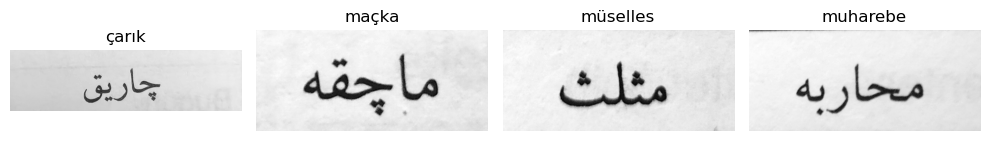

In [17]:
import random

# Rastgele 4 resim seç
resim = image_df.sample(n=4, random_state=32)

plt.figure(figsize=(10, 8))

for i, (file_path, label) in enumerate(zip(resim['file_path'], resim['label'])):
    img = Image.open(file_path).convert('L')
    plt.subplot(1, 4, i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(label)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
def load_and_preprocess_image(image_path, img_size=(128, 128)):

    try:
        # Görüntüyü gri tonlamada aç
        img = Image.open(image_path).convert('L')  # 'L' -> Gri tonlama
        # Görüntüyü yeniden boyutlandır
        img = img.resize(img_size)
        # NumPy dizisine dönüştür ve normalize et
        img = np.array(img) / 255.0
        return img
    except Exception as e:
        raise ValueError(f"Dosya yüklenemedi: {image_path}, Hata: {e}")

# Görüntüleri işleyip NumPy dizisine dönüştür
images = np.array([load_and_preprocess_image(fp) for fp in image_df['file_path']])

# Etiketleri hazırlama
input_texts = image_df['label'].values
target_texts = image_df['label'].values

### Model Girdi ve Çıktıları
Bu aşamada modelin girdi ve çıktıları alınır ve sayısal değer atanır

"merhaba dünya" => {"merhaba":1,"dünya":2} gibi.

texts_to_sequences => daha sonra kelime sırasına uygun bir şekilde dizi oluşturur = {"adım ömer","yapay zeka"} => [[1,2],[3,4]]

max_sequneces_len => En uzun dizinin uzunluğunu bulur =   --[[1,2],[1,2,3]] --  max_sequneces_len = 3 

Uzunluğu eşit olmayan dizinlerin uzunlukları eşitlenir ve eşitlemek için 0 rakamı koyulur , sıfırların dizinin sonuna eklenmesi için "post" kullanılır.

[[1,2,0]  ,[1,0,0] , [1,2,3]]

In [12]:
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(input_texts)
input_sqeuences = tokenizer.texts_to_sequences(input_texts)
target_sequences = tokenizer.texts_to_sequences(target_texts)

max_sequneces_len = max(len(seq) for seq in input_sqeuences)
input_sqeuences = pad_sequences(input_sqeuences, maxlen=max_sequneces_len, padding='post')
target_sequences = pad_sequences(target_sequences, maxlen=max_sequneces_len, padding='post')



In [15]:
target_texts

array(["a'dâ ", "a'dâd ", "a'lem ", ..., 'âğişte', 'âğâz', 'âş'],
      dtype=object)

In [16]:
image_input = Input(shape=(128, 128, 1))

x = Conv2D(32, (3, 3), activation='relu', padding='same')(image_input)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)

x = Flatten()(x)

x = Dense(256, activation='relu')(x)
x = RepeatVector(max_sequneces_len)(x)

### Dil Modeli

Giriş verisi tanımlanır, max_sequences_len 'in uzunluğunu alır = [1,2,3,7] -- (4 uzuunluğunda dizin)

Embedding katmanı, dizinleri daha anlamlı sayısal vektöre dönüştürür. Her dizini 128 boyutlu bir vektöre dönüştürür. 

tokenizer.word_index)+1 = modelin öğrenmesi gereken kelime sayısını belirler, +1 sıfırncı indexi kaldırmak için



In [17]:
# Dil Modeli LSTM çevri
text_input = Input(shape=(max_sequneces_len,))
y = Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=128)(text_input)
y = LSTM(500, return_sequences=True)(y) 
y = LSTM(500, return_sequences=True)(y) 

### Encoder Decoder Katmanlarını Birleştirme

Concatenate Encoder ve Decoder birleştirir, iki farklı bilginin ilişkisi öğrenilir.

x: (batch_size, max_sequence_len, 256) ----- y: (batch_size, max_sequence_len, 128) bu iksini birleştirip ==> (batch_size, max_sequence_len, 384) <------> bu şekilde çıktı verir.



In [18]:
# Birleştirme
decoder = tf.keras.layers.concatenate([x,y])
decoder = LSTM(256, return_sequences=True)(decoder)
output = TimeDistributed(Dense(len(tokenizer.word_index)+1, activation='softmax'))(decoder)

In [19]:
model = Model([image_input, text_input], output)
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 32  320         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 64, 64, 32)   0           ['conv2d[0][0]']                 
                                                                                              

In [28]:
X_train_img, X_test_img, X_train_seq, X_test_seq, y_train, y_test = train_test_split(images,
                                                                                     input_sqeuences, 
                                                                                     target_sequences, 
                                                                                     test_size=0.2,random_state= 32)

In [29]:
history = model.fit(
    [X_train_img, X_train_seq], y_train,
    validation_data=([X_test_img, X_test_seq], y_test),
    epochs=30, 
    batch_size=16    
)

Epoch 1/30
83/83 [==============================] - 2s 24ms/step - loss: 0.1954 - accuracy: 0.9758 - val_loss: 0.2214 - val_accuracy: 0.9789
Epoch 2/30
83/83 [==============================] - 2s 23ms/step - loss: 0.1748 - accuracy: 0.9816 - val_loss: 0.2222 - val_accuracy: 0.9799
Epoch 3/30
83/83 [==============================] - 2s 23ms/step - loss: 0.1562 - accuracy: 0.9849 - val_loss: 0.2193 - val_accuracy: 0.9809
Epoch 4/30
83/83 [==============================] - 2s 23ms/step - loss: 0.1386 - accuracy: 0.9854 - val_loss: 0.2189 - val_accuracy: 0.9789
Epoch 5/30
83/83 [==============================] - 2s 23ms/step - loss: 0.1266 - accuracy: 0.9874 - val_loss: 0.2178 - val_accuracy: 0.9789
Epoch 6/30
83/83 [==============================] - 2s 23ms/step - loss: 0.1161 - accuracy: 0.9887 - val_loss: 0.2175 - val_accuracy: 0.9789
Epoch 7/30
83/83 [==============================] - 2s 23ms/step - loss: 0.1081 - accuracy: 0.9899 - val_loss: 0.2174 - val_accuracy: 0.9789
Epoch 8/30
83

In [30]:
# Test doğruluğunu ve kaybını hesapla
test_loss, test_accuracy = model.evaluate([X_test_img, X_test_seq], y_test)

print(f"Test Kaybı: {test_loss}")
print(f"Test Doğruluğu: {test_accuracy}")

11/11 [==============================] - 1s 9ms/step - loss: 0.2355 - accuracy: 0.9718
Test Kaybı: 0.2355237901210785
Test Doğruluğu: 0.9718025922775269


In [43]:
model.save('model2.h5')

In [35]:
def ceviri_tahmin(image_path):
    img = load_and_preprocess_image(image_path)
    img = np.expand_dims(img, axis=0)
    input_seq = np.zeros((1, max_sequneces_len))

    prediction = model.predict([img, input_seq])
    predicted_indices = np.argmax(prediction, axis=-1)

    reverse_word_index = {v: k for k, v in tokenizer.word_index.items()}
    translated_word = ' '.join([reverse_word_index.get(i, '') for i in predicted_indices[0]])
    return translated_word

print(ceviri_tahmin('C:/Users/omerf/Desktop/bazı.jpg'))

1/1 [==============================] - 0s 18ms/step
bazı  


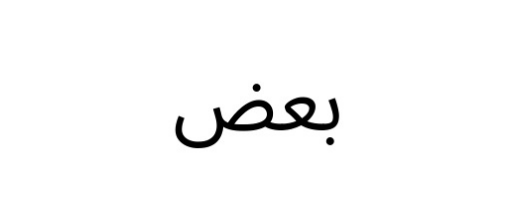

In [39]:
image_path = "C:/Users/omerf/Desktop/bazı.jpg"  
img = mpimg.imread(image_path)
plt.imshow(img)
plt.axis('off')  
plt.show()

In [33]:
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu
from rouge_score import rouge_scorer

### Metrikler

ROUGE-1 == (Recall-Oriented Understudy for Gisting Evaluation), bir metrik ailesidir. ROUGE-1, model tahminindeki tek tek kelimelerin referans metindeki kelimelerle örtüşme oranını ölçer.

ROUGE-2 == modelin tahminindeki iki kelimeden oluşan ardışık dizilerin referans metinle ne kadar örtüştüğünü ölçer.

ROUGE-L == tahmin ve referans metin arasındaki en uzun ortak alt diziyi (Longest Common Subsequence - LCS) bulur ve bu alt dizinin uzunluğunu referans metindeki toplam uzunluğa oranlar.

In [46]:
def calculate_bleu_scores(y_true, y_pred):
    bleu_scores = []
    for true, pred in zip(y_true, y_pred):
        # Her tahmin ve gerçek çifti için BLEU skoru hesapla
        bleu_score = sentence_bleu([true.split()], pred.split(), weights=(0.5, 0.5, 0, 0))  # Unigram ve Bigram ağırlıklı
        bleu_scores.append(bleu_score)
    return bleu_scores

def calculate_rouge_scores(y_true, y_pred):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    rouge_scores = {'rouge1': [], 'rouge2': [], 'rougeL': []}
    for true, pred in zip(y_true, y_pred):
        # Her tahmin ve gerçek çifti için ROUGE skorlarını hesapla
        scores = scorer.score(true, pred)
        for metric in scores:
            rouge_scores[metric].append(scores[metric].fmeasure)
    return rouge_scores

# Tahminler için modelin çıktısını al
y_pred_sequences = model.predict([X_test_img, X_test_seq])

# Tahmin edilen token dizilerini metinlere dönüştür
y_pred_texts = [" ".join([tokenizer.index_word[token] for token in seq if token != 0]) for seq in y_pred_sequences.argmax(axis=2)]

# Gerçek metin dizilerini al
y_true_texts = [" ".join([tokenizer.index_word[token] for token in seq if token != 0]) for seq in y_test]

# BLEU skorlarını hesapla
bleu_scores = calculate_bleu_scores(y_true_texts, y_pred_texts)
avg_bleu = sum(bleu_scores) / len(bleu_scores)


# ROUGE skorlarını hesapla
rouge_scores = calculate_rouge_scores(y_true_texts, y_pred_texts)
avg_rouge1 = sum(rouge_scores['rouge1']) / len(rouge_scores['rouge1'])
avg_rouge2 = sum(rouge_scores['rouge2']) / len(rouge_scores['rouge2'])
avg_rougeL = sum(rouge_scores['rougeL']) / len(rouge_scores['rougeL'])

print(f"Ortalama ROUGE-1 Skoru: {avg_rouge1}")
print(f"Ortalama ROUGE-2 Skoru: {avg_rouge2}")
print(f"Ortalama ROUGE-L Skoru: {avg_rougeL}")

11/11 [==============================] - 0s 34ms/step
Ortalama ROUGE-1 Skoru: 0.9181268882175226
Ortalama ROUGE-2 Skoru: 0.4743202416918429
Ortalama ROUGE-L Skoru: 0.9181268882175226


C:\Users\omerf\anaconda3\envs\tensorGPU\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\omerf\anaconda3\envs\tensorGPU\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\omerf\anaconda3\envs\tensorGPU\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-g

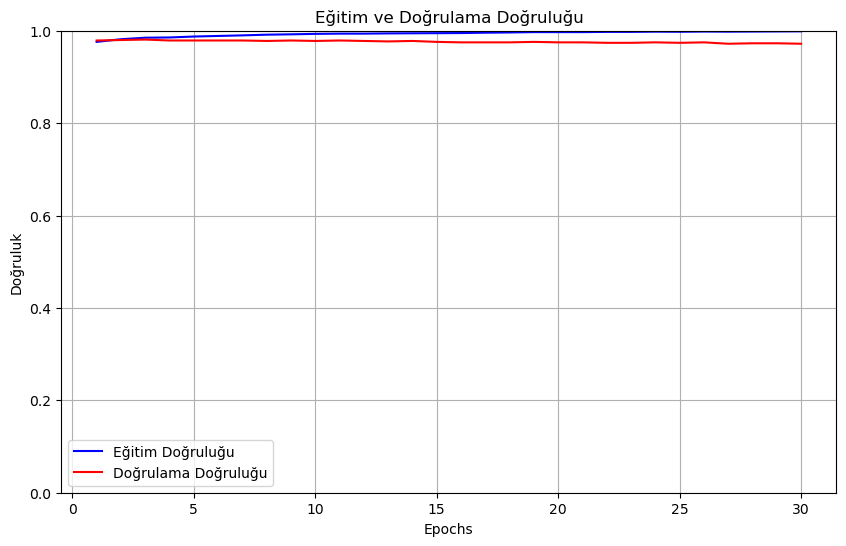

In [40]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

epochs = range(1, len(train_accuracy) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_accuracy, 'b-', label='Eğitim Doğruluğu')
plt.plot(epochs, val_accuracy, 'r-', label='Doğrulama Doğruluğu')
plt.title('Eğitim ve Doğrulama Doğruluğu')
plt.xlabel('Epochs')
plt.ylabel('Doğruluk')
plt.legend()
plt.grid(True)


plt.ylim(0, 1)

plt.show()

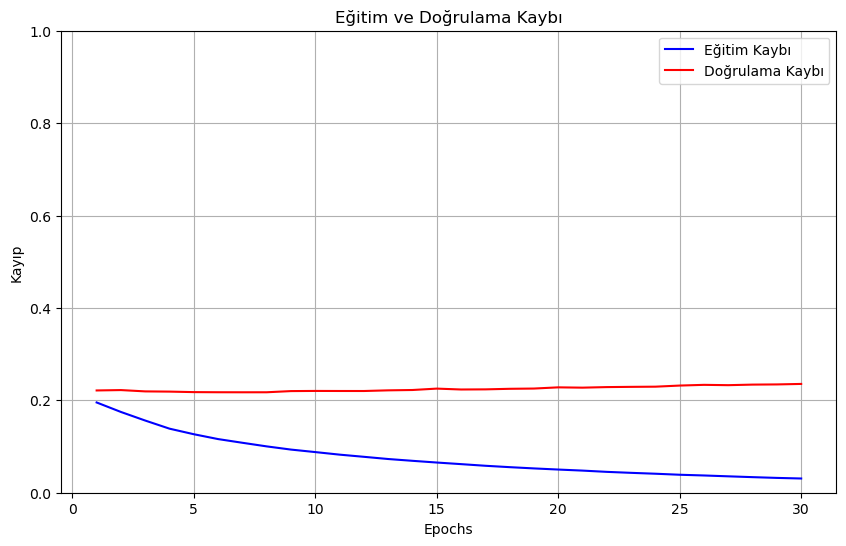

In [45]:
train_loss = history.history['loss']  # Eğitim kaybı değerleri
val_loss = history.history['val_loss']  # Doğrulama kaybı değerleri

epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, 'b-', label='Eğitim Kaybı')
plt.plot(epochs, val_loss, 'r-', label='Doğrulama Kaybı')
plt.title('Eğitim ve Doğrulama Kaybı')
plt.xlabel('Epochs')
plt.ylabel('Kayıp')
plt.legend()
plt.grid(True)

plt.ylim(0, 1)  # Y-ekseni 0 ile 1 arasında ayarlandı

plt.show()


### Precision  (Kesinlik)

Doğru tahmin edilen kelimelerin tüm tahmin edilen kelimelere oranı.

### Recall (Geri Çağırma)

Doğru tahmin edilen kelimelerin tüm doğru kelimelere oranı.

### F-1 Score

Precision ve Recall'un harmonik ortalaması

2 * (Precision * Recall / Precision + Recall)

In [41]:
from sklearn.metrics import classification_report
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
import numpy as np
# Tahminleri al
y_pred = model.predict([X_test_img, X_test_seq], batch_size=16)

# Tahmin edilen sekansları one-hot vektöründen çıkararak düz metin haline dönüştür
y_pred_classes = np.argmax(y_pred, axis=-1)




# y_test ve y_pred sınıf dizilerini düz bir listeye dönüştür
y_pred_flat = [item for seq in y_pred_classes for item in seq]
y_test_flat = [item for seq in y_test for item in seq]

# Ortalama Precision, Recall ve F1-Score hesaplama
precision = precision_score(y_test_flat, y_pred_flat, average='macro')
recall = recall_score(y_test_flat, y_pred_flat, average='macro')
f1 = f1_score(y_test_flat, y_pred_flat, average='macro')

# Sonuçları yazdır
print(f"Ortalama Precision: {precision:.4f}")
print(f"Ortalama Recall: {recall:.4f}")
print(f"Ortalama F1-Score: {f1:.4f}")





21/21 [==============================] - 0s 17ms/step
Ortalama Precision: 0.8464
Ortalama Recall: 0.8492
Ortalama F1-Score: 0.8473


C:\Users\omerf\anaconda3\envs\tensorGPU\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\omerf\anaconda3\envs\tensorGPU\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
